# Forecasting Sticker Sales

# Load Libraries:

In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error

In [192]:
import warnings

warnings.filterwarnings(action="ignore", message="^internal gelsd")
warnings.filterwarnings("ignore")

# Load Dataset:

In [193]:

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [194]:
# Shape of Data
print("train_data shape :",train_data.shape)
print("test_data shape :",test_data.shape)
print("sample_submission shape :",sample_submission.shape)

train_data shape : (230130, 6)
test_data shape : (98550, 5)
sample_submission shape : (98550, 2)


# Loading and Exploring Data:

In [195]:
train_data.head()

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


In [196]:
train_data.describe()

,id,num_sold
count,230130.000000,221259.000000
mean,115064.500000,752.527382
std,66432.953062,690.165445
min,0.000000,5.000000
25%,57532.250000,219.000000
50%,115064.500000,605.000000
75%,172596.750000,1114.000000
max,230129.000000,5939.000000


In [197]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB


In [198]:
train_data['country'].value_counts()

country
Canada       38355
Finland      38355
Italy        38355
Kenya        38355
Norway       38355
Singapore    38355
Name: count, dtype: int64

In [199]:
train_data.isna().sum().sort_values(ascending=False)

num_sold    8871
id             0
date           0
country        0
store          0
product        0
dtype: int64

# Feature Engineering

In [200]:
# Data Preprocessing
def preprocess_data(df):
    df['date'] = pd.to_datetime(df['date'])
    df['Year'] = df['date'].dt.year
    df['Month'] = df['date'].dt.month
    df['Day'] = df['date'].dt.day
    df['Day_of_Week'] = df['date'].dt.dayofweek
    df.drop(['date', 'id'], axis=1, inplace=True, errors='ignore')
    return df

train_data = train_data.dropna()

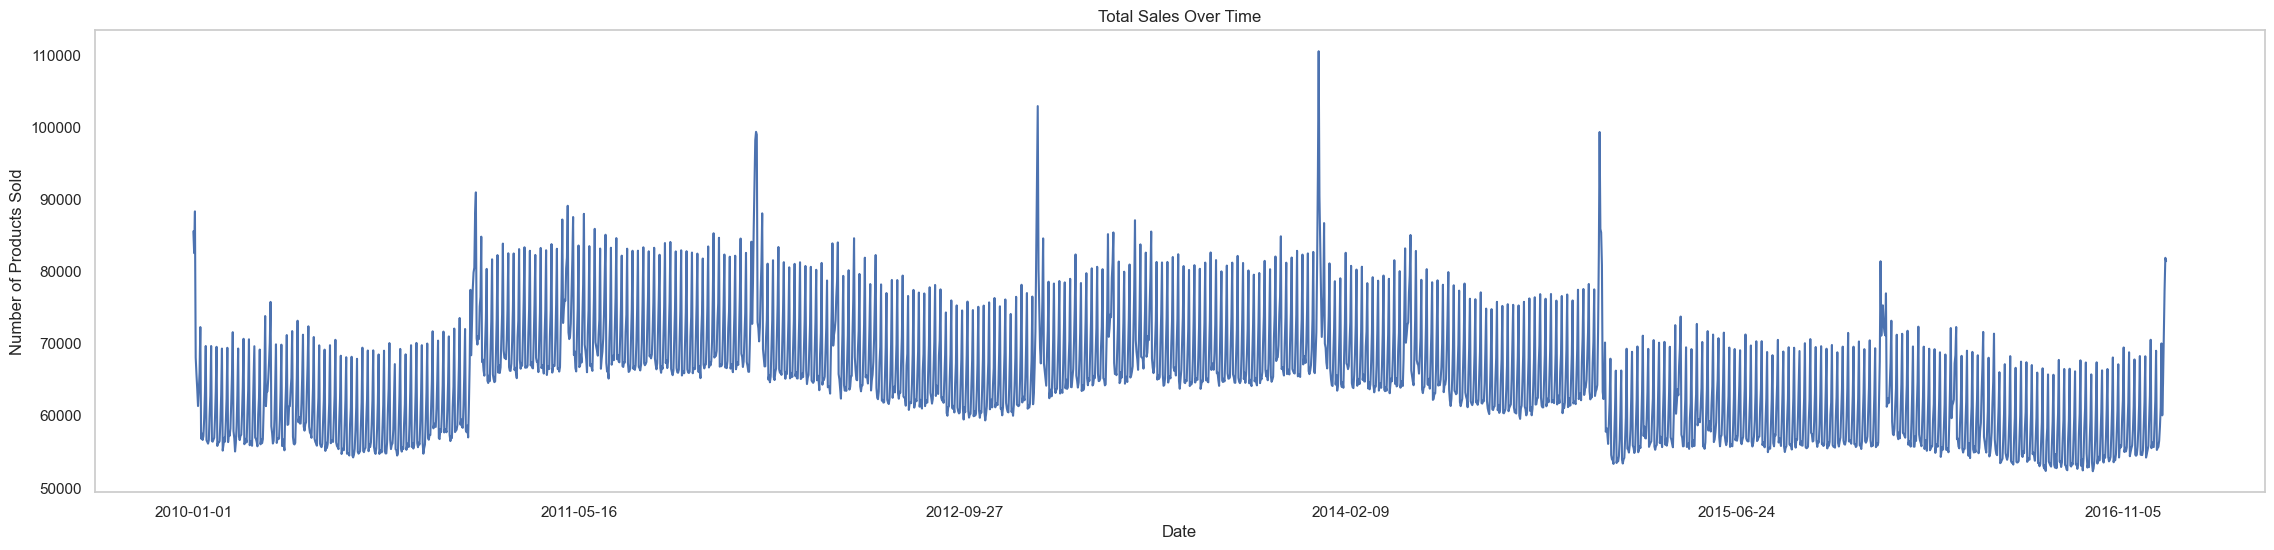

In [201]:
# Visualization
plt.figure(figsize=(28,6))
train_data.groupby('date')['num_sold'].sum().plot(xlabel='Date', 
                                             ylabel='Number of Products Sold', 
                                             title='Total Sales Over Time')
plt.grid()
plt.show()

In [202]:
# Ensure the 'date' column is in datetime format
train_data['date'] = pd.to_datetime(train_data['date'], errors='coerce')

# Check for any invalid dates (NaT values)
if train_data['date'].isna().any():
    print("Some dates couldn't be parsed and were set to NaT. Check your data!")

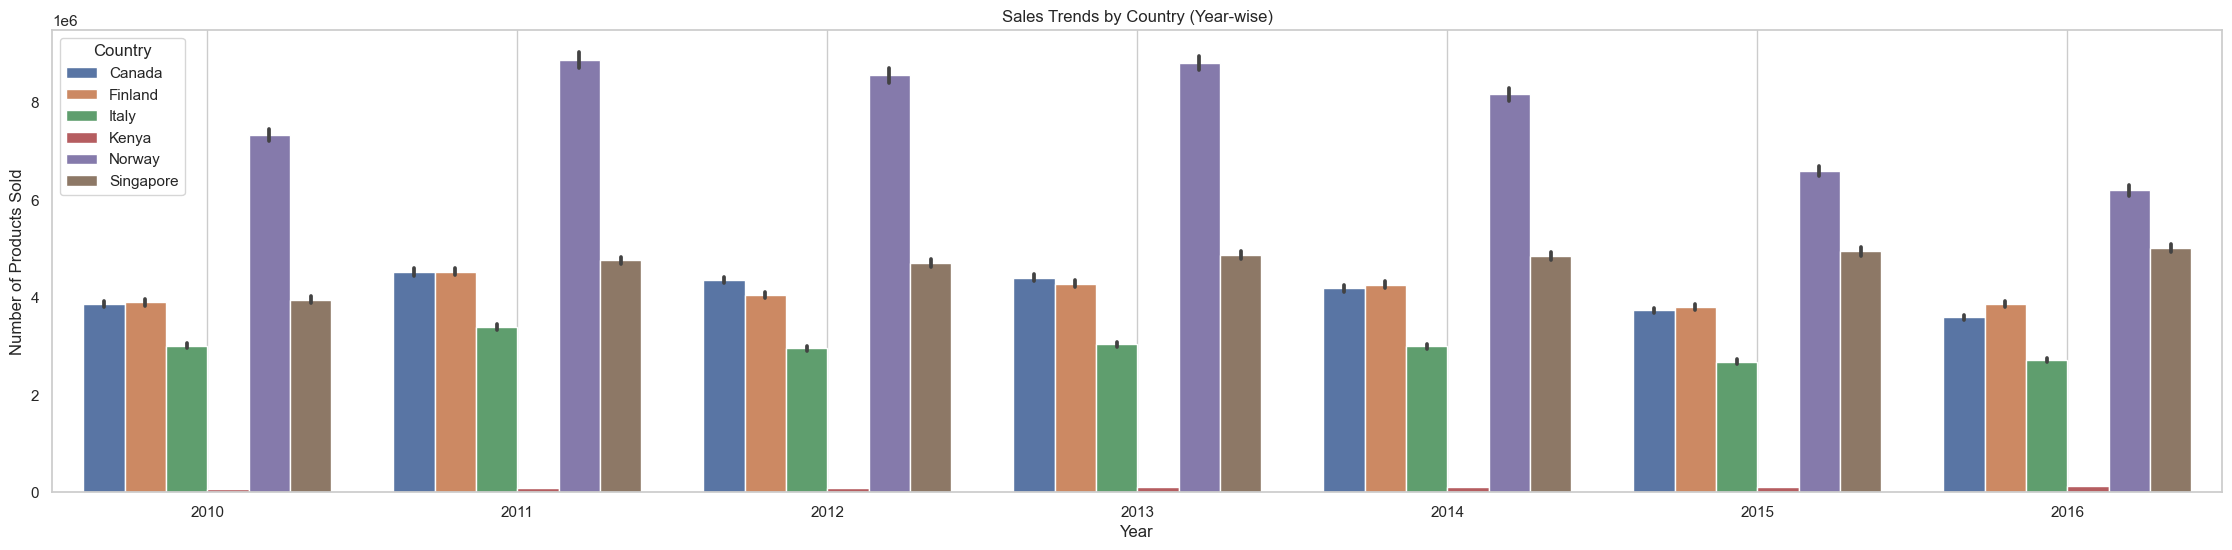

In [ ]:

plt.figure(figsize=(28, 6))

sns.barplot(
    x=train_data['date'].dt.year,
    y=train_data['num_sold'],
    hue=train_data['country'],
    estimator='sum',
    palette='deep'
)

plt.title('Sales Trends by Country (Year-wise)')
plt.xlabel('Year')
plt.ylabel('Number of Products Sold')
plt.legend(title='Country')
plt.grid()
plt.show()

- Initial Distribution Plot (NUM_Sold)

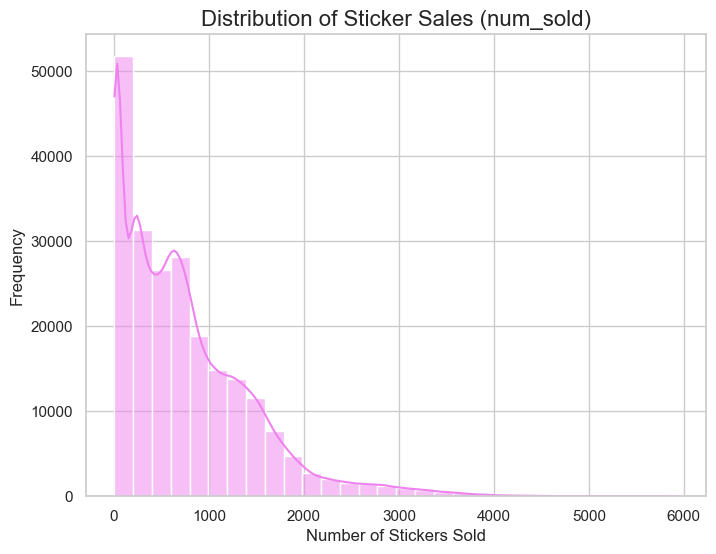

In [204]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
sns.histplot(train_data['num_sold'], kde=True, bins=30, color='violet')

plt.title('Distribution of Sticker Sales (num_sold)', fontsize=16)
plt.xlabel('Number of Stickers Sold')
plt.ylabel('Frequency')

plt.show()



In [205]:
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

In [206]:
# Encoding categorical columns
cat_cols = ['country', 'store', 'product']
train_data = pd.get_dummies(train_data, columns=cat_cols, drop_first=True)
test_data = pd.get_dummies(test_data, columns=cat_cols, drop_first=True)

# Ensure test data has the same columns as train data
test_data = test_data.reindex(columns=train_data.columns.drop('num_sold'), fill_value=0)

- Data transformation

In [207]:
# Define features and target
X = train_data.drop('num_sold', axis=1)
y = np.log1p(train_data['num_sold'])  # Log-transform the target for better modeling

- Corelation Matrix

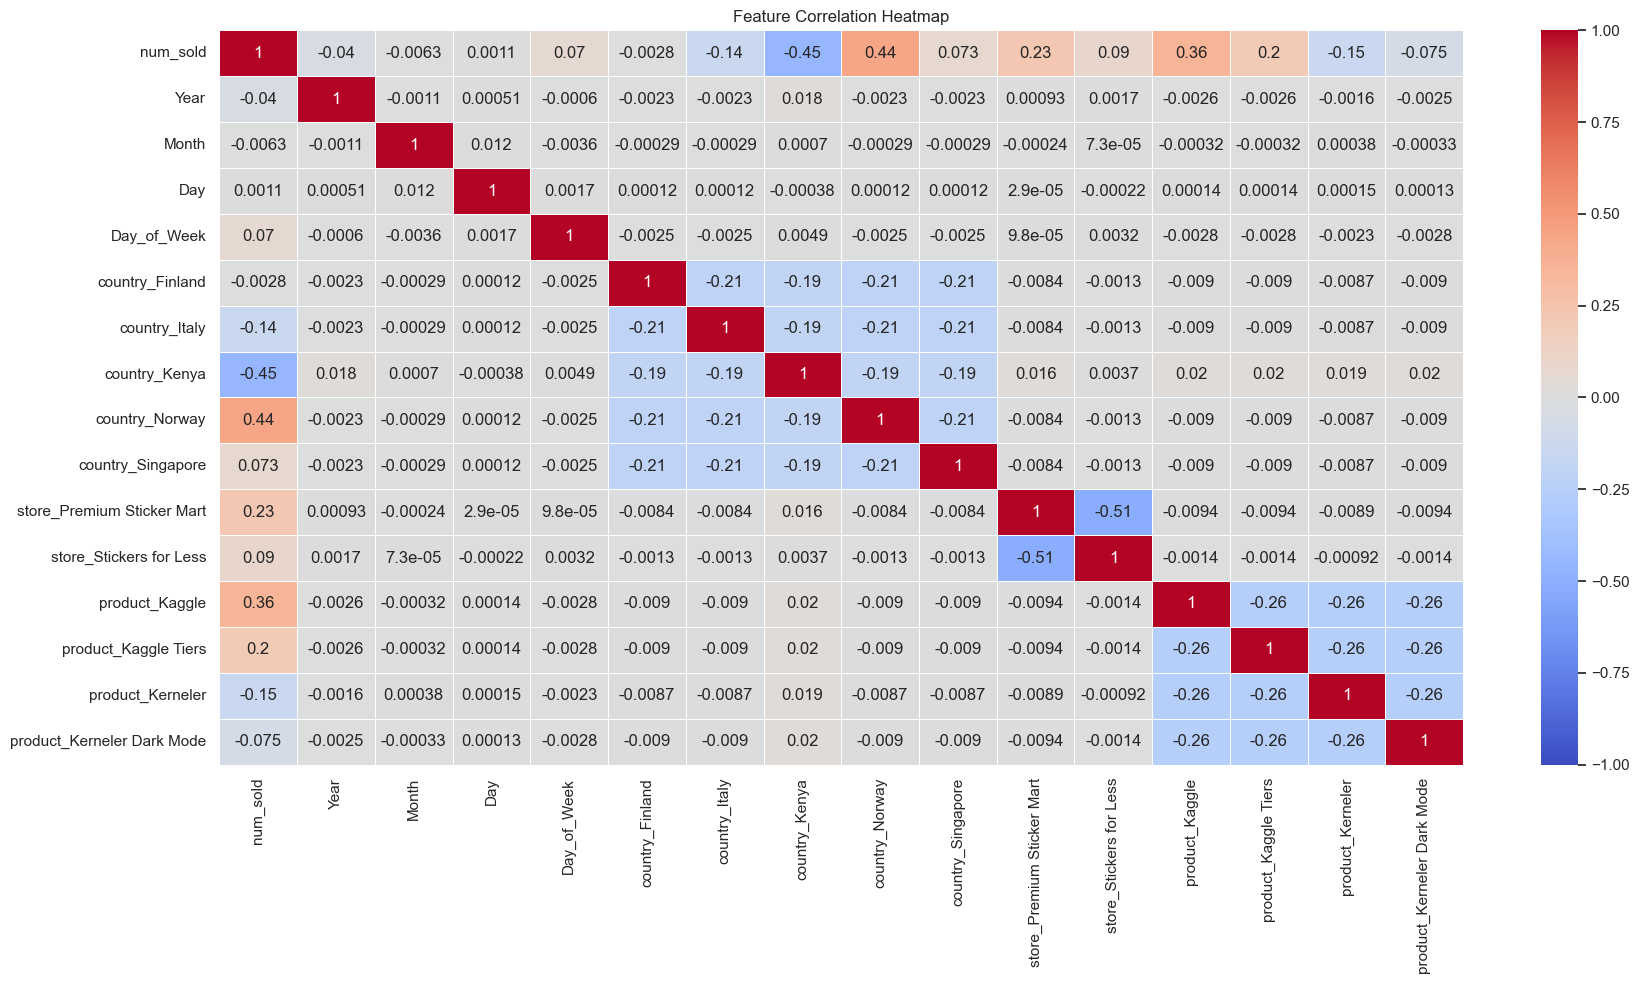

In [208]:
# Calculate the correlation matrix
correlation_matrix = train_data.corr()

# Plot the heatmap
plt.figure(figsize=(18, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

In [209]:
# Analyze correlations with the target variable
target_correlation = correlation_matrix['num_sold'].sort_values(ascending=False)
print("\nCorrelation with target variable (num_sold):")
print(target_correlation)


Correlation with target variable (num_sold):
num_sold                      1.000000
country_Norway                0.444573
product_Kaggle                0.356331
store_Premium Sticker Mart    0.231209
product_Kaggle Tiers          0.197389
store_Stickers for Less       0.089933
country_Singapore             0.073334
Day_of_Week                   0.069613
Day                           0.001137
country_Finland              -0.002843
Month                        -0.006255
Year                         -0.040462
product_Kerneler Dark Mode   -0.075360
country_Italy                -0.139527
product_Kerneler             -0.145131
country_Kenya                -0.449873
Name: num_sold, dtype: float64


- Split the dataset

In [210]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [226]:
X_train.head()

,Year,Month,Day,Day_of_Week,country_Finland,country_Italy,country_Kenya,country_Norway,country_Singapore,store_Premium Sticker Mart,store_Stickers for Less,product_Kaggle,product_Kaggle Tiers,product_Kerneler,product_Kerneler Dark Mode
109844,2013,5,5,6,False,True,False,False,False,True,False,False,False,False,True
36903,2011,2,15,1,False,False,False,False,False,False,False,False,False,True,False
8583,2010,4,6,1,False,True,False,False,False,False,False,False,False,True,False
55231,2011,9,6,1,False,False,False,True,False,False,False,True,False,False,False
120919,2013,9,5,3,False,False,True,False,False,False,False,False,False,False,True


# Evaluation function:

In [211]:
# Mean Absolute Percentage Error (MAPE)
def evaluate_model(model, X_train, X_val, y_train, y_val):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    mape_score = mean_absolute_percentage_error(y_val, y_pred)
    return mape_score

# Model Training (Random Forest & XGB)

- Base Modeling

In [212]:
# Base models
print("Base Model Evaluation")

# Random Forest
rf = RandomForestRegressor(random_state=42)
rf_mape = evaluate_model(rf, X_train, X_val, y_train, y_val)
print(f"Random Forest MAPE: {rf_mape:.4f}")

# XGBoost
xgb = XGBRegressor(random_state=42, verbosity=0)
xgb_mape = evaluate_model(xgb, X_train, X_val, y_train, y_val)
print(f"XGBoost MAPE: {xgb_mape:.4f}")


Base Model Evaluation
Random Forest MAPE: 0.0096
XGBoost MAPE: 0.0086


- Corss Validation

In [213]:
# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

print("\nCross-Validation")

# Random Forest Cross-Validation
rf_cv_scores = cross_val_score(rf, X, y, scoring='neg_mean_absolute_percentage_error', cv=kf)
print(f"Random Forest CV MAPE: {-np.mean(rf_cv_scores):.4f}")

# XGBoost Cross-Validation
xgb_cv_scores = cross_val_score(xgb, X, y, scoring='neg_mean_absolute_percentage_error', cv=kf)
print(f"XGBoost CV MAPE: {-np.mean(xgb_cv_scores):.4f}")


Cross-Validation
Random Forest CV MAPE: 0.0095
XGBoost CV MAPE: 0.0087


- Hyper Parameter Tuning

In [214]:
# Hyperparameter tuning
print("\nHyperparameter Tuning")

# Random Forest Hyperparameter Tuning
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_random = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42), param_distributions=rf_params, 
                               n_iter=20, scoring='neg_mean_absolute_percentage_error', cv=kf, 
                               random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)
print(f"Best Random Forest Params: {rf_random.best_params_}")

# XGBoost Hyperparameter Tuning
xgb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_random = RandomizedSearchCV(estimator=XGBRegressor(random_state=42, verbosity=0), param_distributions=xgb_params, 
                                 n_iter=20, scoring='neg_mean_absolute_percentage_error', cv=kf, 
                                 random_state=42, n_jobs=-1)
xgb_random.fit(X_train, y_train)
print(f"Best XGBoost Params: {xgb_random.best_params_}")


Hyperparameter Tuning
Best Random Forest Params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 20}
Best XGBoost Params: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.2, 'colsample_bytree': 1.0}


- Final Evaluation of Models - Best Parameters

In [215]:
# Final evaluation with best parameters
print("\nFinal Model Evaluation")

# Random Forest with best params
rf_best = rf_random.best_estimator_
rf_best_mape = evaluate_model(rf_best, X_train, X_val, y_train, y_val)
print(f"Tuned Random Forest MAPE: {rf_best_mape:.4f}")

# XGBoost with best params
xgb_best = xgb_random.best_estimator_
xgb_best_mape = evaluate_model(xgb_best, X_train, X_val, y_train, y_val)
print(f"Tuned XGBoost MAPE: {xgb_best_mape:.4f}")


Final Model Evaluation
Tuned Random Forest MAPE: 0.0094
Tuned XGBoost MAPE: 0.0083


- Feature Importance in the final model

In [ ]:
# Feature Importance
best_model = xgb_best  
feature_importances = best_model.feature_importances_
feature_names = X.columns

# Print feature importance as a table
importance_df = pd.DataFrame({
    "Feature Name": feature_names,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

print("\nFeature Importance Table:")
print(importance_df)



Feature Importance Table:
                  Feature Name  Importance
6                country_Kenya    0.778568
11              product_Kaggle    0.044561
12        product_Kaggle Tiers    0.042160
13            product_Kerneler    0.038495
7               country_Norway    0.030507
14  product_Kerneler Dark Mode    0.020442
10     store_Stickers for Less    0.019545
9   store_Premium Sticker Mart    0.014008
5                country_Italy    0.008549
8            country_Singapore    0.001007
0                         Year    0.000657
1                        Month    0.000611
3                  Day_of_Week    0.000512
4              country_Finland    0.000301
2                          Day    0.000079


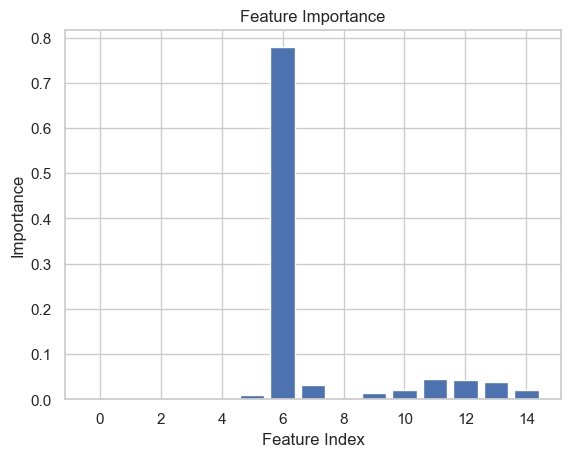

In [ ]:
# Feature Importance
best_model = xgb_best  
plt.bar(range(len(best_model.feature_importances_)), best_model.feature_importances_)
plt.title("Feature Importance")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()

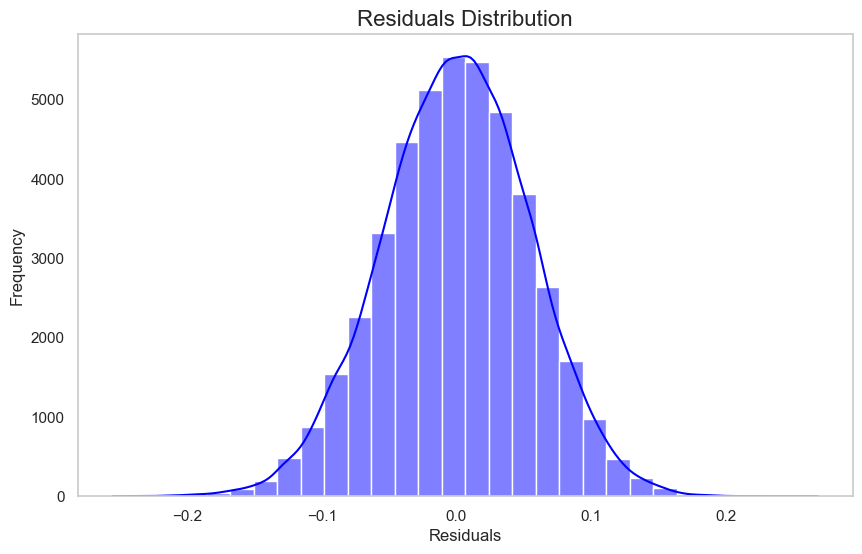

In [218]:
# Residual Analysis
residuals = y_val - xgb_best.predict(X_val)
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30, color='blue')
plt.title('Residuals Distribution', fontsize=16)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# Prediction

In [219]:
# Predictions for submission
final_preds = xgb_best.predict(test_data)
final_preds = np.expm1(final_preds)

# Submission

In [ ]:
submission = pd.DataFrame({'id': sample_submission['id'], 'num_sold': final_preds})
submission.to_csv('submission_xgb_rf.csv', index=False)
print("Submission file saved as submission_xgb_rf.csv")
# Print final predicted entries
print("\nFinal Predicted Entries:")
print(submission.head())

In [220]:
submission = pd.DataFrame({'id': sample_submission['id'], 'num_sold': final_preds})
submission.to_csv('submission_xgb_rf.csv', index=False)
print("Submission file saved as submission_xgb_rf.csv")

Submission file saved as submission_xgb_rf.csv


In [221]:
# Print final predicted entries
print("\nFinal Predicted Entries:")
print(submission.head())


Final Predicted Entries:
       id    num_sold
0  230130  134.033096
1  230131  833.740112
2  230132  742.392883
3  230133  356.790680
4  230134  443.464600


# predictions against sample submission file

In [223]:
# Validate predictions against sample submission
if 'num_sold' in sample_submission.columns:
    comparison = sample_submission.copy()
    comparison['Predicted num_sold'] = final_preds
    print("\nComparison with Sample Submission:")
    print(comparison.head())
else:
    print("\nSample submission file does not contain 'num_sold' column for comparison.")



Comparison with Sample Submission:
       id  num_sold  Predicted num_sold
0  230130       100          134.033096
1  230131       100          833.740112
2  230132       100          742.392883
3  230133       100          356.790680
4  230134       100          443.464600
